In [20]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data and plot the number of ratings per movie and user

number of items: 10000, number of users: 1000
shape of dataset: (10000, 1000)


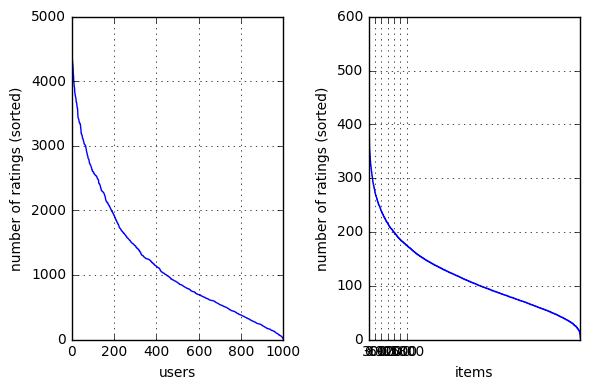

min # of items per user = 8, min # of users per item = 3.


In [81]:
from helpers import load_data, preprocess_data
from plots import plot_raw_data


path_dataset = "../data/data_train.csv"
subset = [100, 101]
#ratings = load_data(path_dataset, subset)
ratings = load_data(path_dataset)
print("shape of dataset:",ratings.shape)
#print(ratings)
#print( ratings[0,9])
#print( ratings[0:5,0:5])
#ratings

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

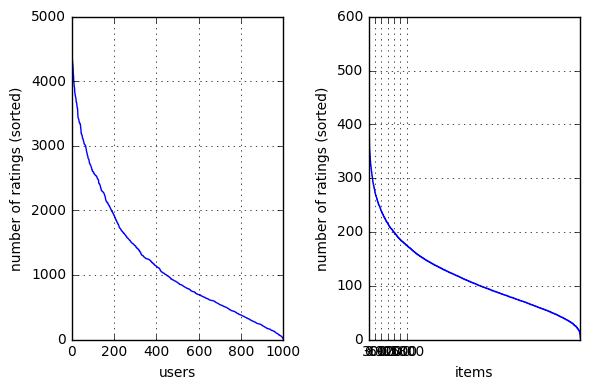

Percentage of nz train data:  0.8998, percentage of nz test data:  0.1002


In [31]:
#Preprocess Data
import helpers as h
import data_preprocess as dp

nz_ratings, nz_row_colindices, nz_col_rowindices = h.build_index_groups(ratings)
user_means = dp.get_user_means(ratings, nz_col_rowindices) 
item_means = dp.get_item_means(ratings, nz_row_colindices)
means = dp.get_global_means(ratings, nz_ratings) 


num_items_per_user, num_users_per_item = plot_raw_data(ratings)
valid_ratings, train, test, stets = ohe.split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

In [42]:
#comparing two methods to each other
methods=['no','global','item','user','combined']

errors_tr = []
errors_te = []

for m in methods:
    test_n = sp.lil_matrix(ratings.shape)
    train_n = sp.lil_matrix(ratings.shape)
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    
    nz_row, nz_col = test.nonzero()
    nz_test  = list(zip(nz_row, nz_col))
    
    ratings_normalized, train_mean = dp.get_unbiased_matrix(ratings.copy(),user_means,item_means,means,m)
    
    for i,j in nz_train:
        train_n[i,j] = ratings_normalized[i,j]
        
    for i,j in nz_test:
        test_n[i,j] = ratings_normalized[i,j]


    print("generating item and user feature matrices")
    item_features, user_features, train_errors, test_errors = ohe.ALS(
        train_n, test_n,8, 0.06255, 1e-4)
    
    errors_tr.append(train_errors)
    errors_te.append(test_errors)

no method ok
generating item and user feature matrices
iter: 0, RMSE on training set: 1.0644450779958634.
iter: 0, RMSE on test set: 1.085413562531082.
iter: 1, RMSE on training set: 1.0111386513630891.
iter: 1, RMSE on test set: 1.0507708922711148.
iter: 2, RMSE on training set: 0.9440962897987073.
iter: 2, RMSE on test set: 1.034665010000562.
iter: 3, RMSE on training set: 0.9150430876493384.
iter: 3, RMSE on test set: 1.021891756895568.
iter: 4, RMSE on training set: 0.9006906238237546.
iter: 4, RMSE on test set: 1.0117167068540496.
iter: 5, RMSE on training set: 0.8913087916776604.
iter: 5, RMSE on test set: 1.0043620468423475.
iter: 6, RMSE on training set: 0.8846046148665229.
iter: 6, RMSE on test set: 0.9988125608161402.
iter: 7, RMSE on training set: 0.8795768094586833.
iter: 7, RMSE on test set: 0.9944043745084961.
iter: 8, RMSE on training set: 0.8756984132901864.
iter: 8, RMSE on test set: 0.9907834052713334.
iter: 9, RMSE on training set: 0.8726685365692205.
iter: 9, RMSE o

In [98]:
#create submission with standardized dataset
import helpers as h
import data_preprocess as dp

nz_ratings, nz_row_colindices, nz_col_rowindices = h.build_index_groups(ratings)
user_means = dp.get_user_means(ratings.copy(), nz_col_rowindices) 
item_means = dp.get_item_means(ratings.copy(), nz_row_colindices)
means = dp.get_global_means(ratings.copy(), nz_ratings) 

ratings_normalized, train_mean = dp.get_unbiased_matrix(ratings.copy(),user_means,item_means,means,'combined')



#ratings_unnormalized, train_mean = dp.get_unbiased_matrix(ratings_normalized.copy(),-user_means,-item_means,-means,'combined')

#print((ratings!=ratings_unnormalized).nnz==0 )

combined ok


In [112]:
#print(user_means[0])
#print(item_means[0])
#print(means[0])
#print(train_mean[0])
#print(ratings_normalized[0])
#print(ratings_full[0])
combined_means = user_means + item_means - means
train_mm = train_mean.todense()
print(train_mm[0])
predictions = ratings_full + train_mm
print(predictions[0])
#print((ratings_full+train_mean)[0])

ValueError: operands could not be broadcast together with shapes (1000,1) (10000,1) 

In [83]:
item_features, user_features, train_errors, test_errors = ohe.ALS(
        ratings_normalized, ratings_normalized,8, 0.06255, 1e-4)

ratings_full = np.dot(np.transpose(item_features),user_features)


iter: 0, RMSE on training set: 0.9888425813157217.
iter: 0, RMSE on test set: 0.9888425813157217.
iter: 1, RMSE on training set: 0.9762053865112374.
iter: 1, RMSE on test set: 0.9762053865112374.
iter: 2, RMSE on training set: 0.9208838633300981.
iter: 2, RMSE on test set: 0.9208838633300981.
iter: 3, RMSE on training set: 0.8952725430874793.
iter: 3, RMSE on test set: 0.8952725430874793.
iter: 4, RMSE on training set: 0.8884677821631751.
iter: 4, RMSE on test set: 0.8884677821631751.
iter: 5, RMSE on training set: 0.8846375252891006.
iter: 5, RMSE on test set: 0.8846375252891006.
iter: 6, RMSE on training set: 0.8818805849785731.
iter: 6, RMSE on test set: 0.8818805849785731.
iter: 7, RMSE on training set: 0.879745083323184.
iter: 7, RMSE on test set: 0.879745083323184.
iter: 8, RMSE on training set: 0.8780878831151339.
iter: 8, RMSE on test set: 0.8780878831151339.
iter: 9, RMSE on training set: 0.8768379598922879.
iter: 9, RMSE on test set: 0.8768379598922879.
iter: 10, RMSE on trai

In [84]:
import our_helpers as ohe
print(ohe.compute_error2(ratings, ratings_full, nz_ratings) )
ratings_full_n, train_mean = dp.get_unbiased_matrix(ratings_full.copy(),-user_means,-item_means,-means,'combined')
print(ohe.compute_error2(ratings, ratings_full_n, nz_ratings) )

print(ratings_full_n[0])
#print(item_means[0])

15.9212046533
combined ok
0.872773461115
  (0, 0)	7.476098675808223
  (0, 1)	7.61563061142495
  (0, 2)	7.6075769774352775
  (0, 3)	7.937709241695926
  (0, 4)	7.740537683562474
  (0, 5)	8.565775833858538
  (0, 6)	7.294333704788205
  (0, 7)	7.991951103561249
  (0, 8)	7.47591444871551
  (0, 9)	3.8630152838167726
  (0, 10)	7.434140860876989
  (0, 11)	7.28225752849356
  (0, 12)	7.458266964346723
  (0, 13)	7.959882560127931
  (0, 14)	7.3294007871933085
  (0, 15)	7.419550282063382
  (0, 16)	7.292910519956179
  (0, 17)	7.070315499817192
  (0, 18)	7.7303189718913226
  (0, 19)	7.539286774477613
  (0, 20)	7.357502403126445
  (0, 21)	7.2454769712679505
  (0, 22)	7.377389350361675
  (0, 23)	7.948863888637269
  (0, 24)	7.440398357350065
  (0, 25)	8.100348930874764
  (0, 26)	7.84778258968957
  (0, 27)	8.08056748813948
  (0, 28)	8.019494916961323
  (0, 29)	7.81820104899845
  (0, 30)	7.426379782891787
  (0, 31)	7.349751375777258
  (0, 32)	7.561354971997026
  (0, 33)	7.196513886504286
  (0, 34)	6.961035

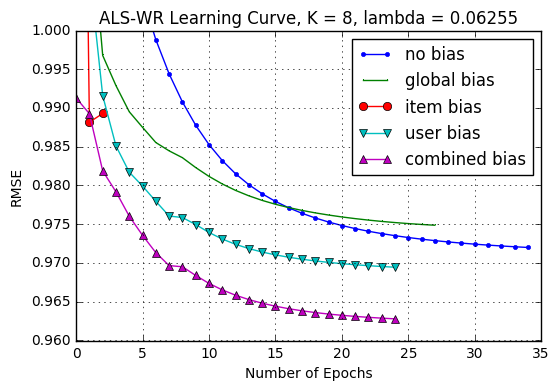

In [48]:
import plots as pl
    
lambda_ = 0.06255
K = 8
x_axis_name = "Number of Epochs"
y_axis_name = "RMSE"
lambda_str = ('%f' % lambda_).rstrip('0').rstrip('.')
title= "ALS-WR Learning Curve, K = %d, lambda = %s"%(K,lambda_str)
labels =[ methods[i] + " bias" for i in range(len(methods))]
path = "Bias/%d_%s.jpg"%(K,lambda_str)
pl.plot_general (errors_te, labels ,x_axis_name, y_axis_name, title, path)

## Run to estimate model

[autoreload of plots failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/home/manana/Machine_Learning_Recommender_Systems/src/plots.py", line 75
    
    ^
SyntaxError: unexpected EOF while parsing
]


splitting data
Percentage of nz train data:  0.8998, percentage of nz test data:  0.1002
generating item and user feature matrices
iter: 0, RMSE on training set: 1.9115616543069462.
iter: 0, RMSE on test set: 2.091750565057215.
iter: 1, RMSE on training set: 0.9075503445706536.
iter: 1, RMSE on test set: 1.4378892121765305.
iter: 2, RMSE on training set: 0.6066410844679037.
iter: 2, RMSE on test set: 1.3535310884088354.
iter: 3, RMSE on training set: 0.4903986605787287.
iter: 3, RMSE on test set: 1.2691156778535482.
iter: 4, RMSE on training set: 0.4339290256469746.
iter: 4, RMSE on test set: 1.2078307861088209.
iter: 5, RMSE on training set: 0.40181750410418815.
iter: 5, RMSE on test set: 1.1656331086971545.
iter: 6, RMSE on training set: 0.38144635295449.
iter: 6, RMSE on test set: 1.135892015685141.
iter: 7, RMSE on training set: 0.3675266266860978.
iter: 7, RMSE on test set: 1.114255538077308.
iter: 8, RMSE on training set: 0.35750877935731773.
iter: 8, RMSE on test set: 1.09806884

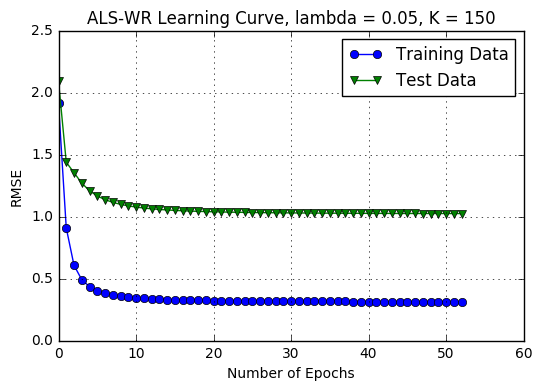

1.01567306874


In [43]:
import our_helpers as ohe
import plots as pl

#defining parameters

lambda_ = 0.05
K = 150
stop_criterion = 1e-4


print("splitting data")
valid_ratings, train, test = ohe.split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)
np.random.seed(600)

print("generating item and user feature matrices")
item_features, user_features, train_errors, test_errors = ohe.ALS(
    train, test,K, lambda_, stop_criterion,  rng)

#creating plot
lambda_str = ('%f' % lambda_).rstrip('0')
path = "%s_%d_%d.jpg"%(lambda_str, K, len(train_errors))
pl.plot_train_test_errors(train_errors, test_errors, lambda_str , K , path, len(train_errors))

#
full_ratings = np.dot( item_features.transpose(), user_features)
nz_rows, nz_cols = test.nonzero()
nz_test = list( zip(nz_rows, nz_cols))

full_ratings_b = ohe.bias_correction(full_ratings, ratings)
print(compute_error2(test, full_ratings_b, nz_test) )


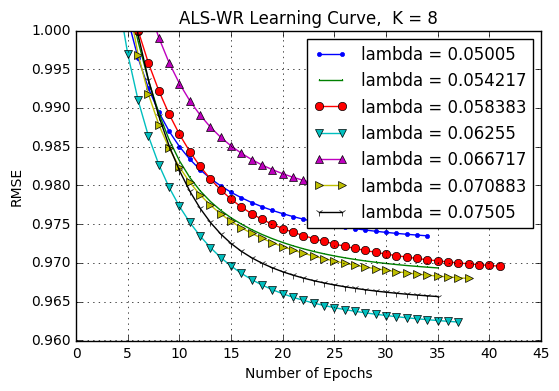

In [14]:
#print(len(errors))
#print(len(errors[0]))
#print(len(errors[1]))
#print(len(max(errors, key=len)))
#path = "K%d/test_cv_rmse_l%d_nsp%d.jpg"%(num_features, len(lambdas),n_splits )
pl.plot_cv_errors(errors, lambdas, num_features, path)


number of different lambdas :  1
1 / 1
lambda  =  0.06255
iter: 0, RMSE on training set: 1.063890771751742.
iter: 0, RMSE on test set: 1.0855655682340715.
iter: 1, RMSE on training set: 1.0124272788392852.
iter: 1, RMSE on test set: 1.0526244743408593.
iter: 2, RMSE on training set: 0.9476531238109778.
iter: 2, RMSE on test set: 1.0385276054744133.
iter: 3, RMSE on training set: 0.9153795864026912.
iter: 3, RMSE on test set: 1.0218544001779768.
iter: 4, RMSE on training set: 0.9005703084737285.
iter: 4, RMSE on test set: 1.0095744975471874.
iter: 5, RMSE on training set: 0.8913612837411579.
iter: 5, RMSE on test set: 1.0014696355281665.
iter: 6, RMSE on training set: 0.8847154511724599.
iter: 6, RMSE on test set: 0.9955161629802453.
iter: 7, RMSE on training set: 0.8796575020505798.
iter: 7, RMSE on test set: 0.9909341473588775.
iter: 8, RMSE on training set: 0.8757367925093622.
iter: 8, RMSE on test set: 0.9873438204948803.
iter: 9, RMSE on training set: 0.872665882953649.
iter: 9, RM

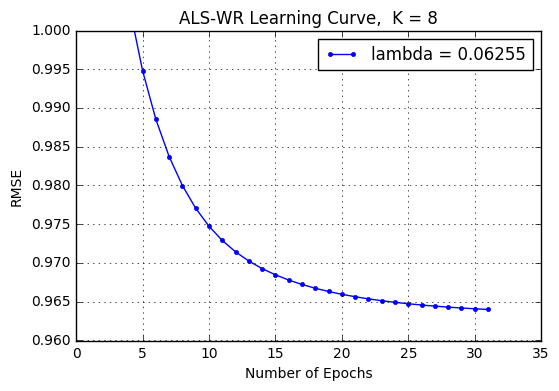

smallest avg error:  0.970225310374


UnboundLocalError: local variable 'stest' referenced before assignment

In [19]:
import our_helpers as ohe
import plots as pl

#ohe.main(ratings)



"""Alternating Least Squares (ALS) algorithm."""
# define parameters
num_features = 8   # K in the lecture notes
lambda_user = 0.3
lambda_item = 0.3
stop_criterion = 1e-4
n_splits = 10

    
#initialization
sratings = sp.lil_matrix(ratings)
train_errors = []
test_errors = []
    
#lambdas = np.linspace( 0.05005, 0.07505, 7)
lambdas = [0.06255]
    
print("number of different lambdas : ",len(lambdas))
    
# set seed
np.random.seed(988)
    
    
test_avg_cost, train_avg_cost , errors = ohe.cross_validation(
sratings, n_splits, num_features, lambdas, stop_criterion)
    
#generating plot
path = "/K%d/l%d_%f_%f.jpg"%(num_features, len(lambdas),lambdas[0],lambdas[-1] )
    
pl.plot_cv_errors(errors, lambdas, num_features, path)
    
ind = np.argmin(test_avg_cost)
print("smallest avg error: ",test_avg_cost[ind])
    
lambda_ = lambdas[ind]
    
    
vl, train, test = ohe.split_data(ratings, num_items_per_user, num_users_per_item,0)
    
item_features , user_features , rmse_tr, rmse_te = ALS (
train , test, num_features,lambda_[0], 
lambda_[1], stop_criterion,error_list, 250 )
    
ratings_full = np.dot(np.transpose(item_features),user_features)

# Create Sumbmissions

In [58]:
from our_helpers import create_submission
path_output = "submission_0.06255_norm.csv"

#create_submission(path_output, full_ratings_b)

create_submission(path_output, ratings_full_n )

number of items: 10000, number of users: 1000


# test ALT

In [13]:
print(X_filled_nnm_2.shape)
error = ohe.compute_error2(test, X_filled_nnm_2, nz_test)
print(error)

(10000, 1000)
1.03818504741


In [6]:
#scored 1.05
import fancyimpute as fi
import our_helpers as ohe

valid_ratings, train, test,stest = ohe.split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1,sparse= False)

print(data.shape)
nz_rows, nz_cols = stest.nonzero()
nz_test = list( zip(nz_rows, nz_cols))
train[train == 0 ] = 'nan'
X_filled_nnm_1 = fi.SoftImpute().complete(train)
error = ohe.compute_error2(test, X_filled_nnm_1, nz_test)
print(error)

(10000, 1000)
[SoftImpute] Max Singular Value of X_init = 141.828063
[SoftImpute] Iter 1: observed MAE=0.064029 rank=999
[SoftImpute] Iter 2: observed MAE=0.064057 rank=999
[SoftImpute] Iter 3: observed MAE=0.064076 rank=998
[SoftImpute] Iter 4: observed MAE=0.064087 rank=995
[SoftImpute] Iter 5: observed MAE=0.064087 rank=991
[SoftImpute] Iter 6: observed MAE=0.064082 rank=988
[SoftImpute] Iter 7: observed MAE=0.064070 rank=984
[SoftImpute] Iter 8: observed MAE=0.064049 rank=978
[SoftImpute] Iter 9: observed MAE=0.064015 rank=970
[SoftImpute] Iter 10: observed MAE=0.063974 rank=964
[SoftImpute] Iter 11: observed MAE=0.063930 rank=957
[SoftImpute] Iter 12: observed MAE=0.063880 rank=949
[SoftImpute] Iter 13: observed MAE=0.063818 rank=939
[SoftImpute] Iter 14: observed MAE=0.063751 rank=932
[SoftImpute] Iter 15: observed MAE=0.063686 rank=924
[SoftImpute] Iter 16: observed MAE=0.063619 rank=916
[SoftImpute] Iter 17: observed MAE=0.063544 rank=906
[SoftImpute] Iter 18: observed MAE=0.06

In [11]:
import fancyimpute as fi
import our_helpers as ohe

X_filled_nnm_2 = fi.NuclearNormMinimization().complete(train)
error = ohe.compute_error2(test, X_filled_nnm, nz_test)
print(error)

KeyboardInterrupt: 

In [5]:
import fancyimpute as fi
import our_helpers as ohe

data_norm = fi.BiScaler(train)
X_filled_nnm_2 = fi.MatrixFactorization(rank=2,l1_penalty=0.065, l2_penalty=0.065).complete(train)
error = ohe.compute_error2(test, X_filled_nnm_2, nz_test)
print(error)

AttributeError: module 'fancyimpute' has no attribute 'BiScaler'

In [ ]:
#1.03 achvenebda fancyiomputis matrix factorization metodi, kaggleze = 1.05776